*Import Libraries and define Tiff File*

In [1]:
import math
import json
import sys
import pandas as pd
# import rasterio
# from rasterio.mask import mask
from libtiff import TIFF
import sys
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join
import pickle
import h5py
import scipy.misc
import seaborn as sns
import math
import os
import matplotlib.pyplot as plt

tiffFileName='viirsDistrictLevel/India_2012-10-01_2012-10-31_500.tif'
jsonFileName='viirsDistrictLevel/Census_2011/2011_Dist.geojson'
inputFolder=tiffFileName[:-4]
if not os.path.exists(inputFolder):
    os.makedirs(inputFolder)
csv_outfile_name = inputFolder+".csv" 
csv_outfile_name1 = inputFolder+"_log.csv" 

**Break Into Districts**

In [3]:
countryData = json.loads(open(jsonFileName).read())
for currDistrictFeature in countryData["features"]:
    # currDistrictFeature=countryData["features"][0]
    distName=currDistrictFeature["properties"]['DISTRICT']
    st_cen_cd=currDistrictFeature["properties"]['ST_CEN_CD']
    censuscode=currDistrictFeature["properties"]['censuscode']
    geoms=currDistrictFeature["geometry"]
    listGeom=[]
    listGeom.append(geoms)
    geoms=listGeom
    with rasterio.open(tiffFileName) as src:
      out_image, out_transform = mask(src, geoms, crop=True)

    out_meta = src.meta.copy()

        # save the resulting raster  
    out_meta.update({"driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform})

    with rasterio.open(inputFolder+'/'+distName+'@'+str(st_cen_cd)+'@'+str(censuscode)+".tif", "w", **out_meta) as dest:
      dest.write(out_image)

**Reading all the District Files into a Dictionary**

In [2]:
onlyfiles = [f for f in listdir(inputFolder) if isfile(join(inputFolder, f))]
flattened_DataDictionary={}

In [3]:
allFlattenedArray = None
for currDFile in onlyfiles:
    #currDistrictFile='districtTiffFiles/Rajkot@24@476.tif'
    currDistrictFile=(inputFolder+'/'+currDFile)
    tif = TIFF.open(currDistrictFile, mode='r')
    image = tif.read_image()
    dataAll = np.array(image)
    flattenData=dataAll.flatten()
    flattenData=flattenData[flattenData != 0]
    flattened_DataDictionary[currDFile]=flattenData
    if (allFlattenedArray is None):
        allFlattenedArray = flattenData
    else:
        allFlattenedArray = np.append(allFlattenedArray,flattenData)

In [8]:
allFlattenedArray_log=np.log(2+allFlattenedArray)
allFlattenedArray_log = allFlattenedArray_log[~np.isnan(allFlattenedArray_log)]
print(allFlattenedArray_log.shape)
print("Pixels Percentage removed are",(allFlattenedArray.shape[0]-allFlattenedArray_log.shape[0])*100.0/(allFlattenedArray.shape[0]))
print('Max Value :',allFlattenedArray_log.max())
print('Min Value :',allFlattenedArray_log.min())

(13907535,)
Pixels Percentage removed are 0.0
Max Value : 7.9109383
Min Value : 0.46357322


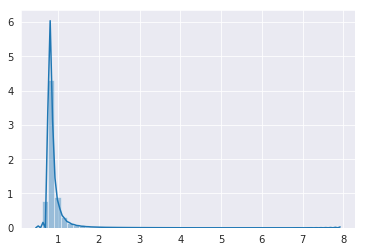

In [9]:
sns.set_style('darkgrid')
sns.distplot(allFlattenedArray_log)

In [43]:
numBins=25
multiplier = int(100/numBins)
bins_percentile = [multiplier*x for x in range(numBins+1)]
percentileValues = [np.percentile(allFlattenedArray_log, a) for a in bins_percentile]
print(percentileValues)

[0.4635732173919678, 0.7425161600112915, 0.7539700269699097, 0.7624248266220093, 0.7696075963973998, 0.7762268781661987, 0.7826015949249268, 0.7889326810836792, 0.7954173684120178, 0.802185595035553, 0.8093535304069519, 0.8168667554855347, 0.824663519859314, 0.8327552676200867, 0.8413621187210083, 0.8508374691009521, 0.8616189360618591, 0.8743586611747742, 0.8903755521774293, 0.9120008945465088, 0.9413727521896362, 0.9811215734481811, 1.039041142463684, 1.1368129587173463, 1.3652338266372666, 7.910938262939453]


In [42]:
numBins=50
multiplier = int(100/numBins)
bins_percentile = [multiplier*x for x in range(numBins+1)]
percentileValues = [np.percentile(allFlattenedArray_log, a) for a in bins_percentile]
print(percentileValues)

[0.4635732173919678, 0.7333897566795349, 0.7425161600112915, 0.7488344311714172, 0.7539700269699097, 0.758419394493103, 0.7624248266220093, 0.7661200761795044, 0.7696075963973998, 0.7729689478874207, 0.7762268781661987, 0.7794266939163208, 0.7826015949249268, 0.785757303237915, 0.7889326810836792, 0.79215008020401, 0.7954173684120178, 0.7987563014030457, 0.802185595035553, 0.8057227730751038, 0.8093535304069519, 0.8130707478523254, 0.8168667554855347, 0.8207302093505859, 0.824663519859314, 0.8286640644073486, 0.8327552676200867, 0.8369796276092529, 0.8413621187210083, 0.8459725046157837, 0.8508374691009521, 0.8560367226600647, 0.8616189360618591, 0.8676866292953491, 0.8743586611747742, 0.8818238377571106, 0.8903755521774293, 0.9003210854530335, 0.9120008945465088, 0.9256075954437255, 0.9413727521896362, 0.9596490788459777, 0.9811215734481811, 1.0069584846496582, 1.039041142463684, 1.0804179430007934, 1.1368129587173463, 1.2203242683410642, 1.3652338266372666, 1.7070042991638186, 7.9109

In [40]:
numBins=75
multiplier = (100.0/numBins)
bins_percentile = [multiplier*x for x in range(numBins+1)]
percentileValues = [np.percentile(allFlattenedArray_log, a) for a in bins_percentile]
print(percentileValues)

[0.4635732173919678, 0.7285976155598959, 0.7369933724403381, 0.7425161600112915, 0.7468882203102112, 0.7506370544433594, 0.7539700269699097, 0.7569922804832458, 0.7597969770431519, 0.7624248266220093, 0.7649158239364624, 0.7673068046569824, 0.7696075963973998, 0.7718580961227417, 0.7740582243601482, 0.7762268781661987, 0.7783636450767517, 0.7804867029190063, 0.7826015949249268, 0.7847074270248413, 0.7868139743804932, 0.7889326810836792, 0.7910741567611694, 0.7932352423667908, 0.7954173684120178, 0.7976316809654236, 0.7998892068862915, 0.802185595035553, 0.8045335412025452, 0.8069280163447062, 0.8093535304069519, 0.8118268251419067, 0.8143250346183777, 0.8168667554855347, 0.8194390535354614, 0.8220331072807312, 0.824663519859314, 0.8273106217384338, 0.8300145864486694, 0.8327552676200867, 0.8355565071105957, 0.8384175602595011, 0.8413621187210083, 0.8444119691848755, 0.8475587368011475, 0.8508374691009521, 0.854263424873352, 0.8578485830624898, 0.8616189360618591, 0.8656072020530701, 0.

In [41]:
numBins=125
multiplier = (100.0/numBins)
bins_percentile = [multiplier*x for x in range(numBins+1)]
percentileValues = [np.percentile(allFlattenedArray_log, a) for a in bins_percentile]
print(percentileValues)

[0.4635732173919678, 0.7226079106330872, 0.7307290487289428, 0.7356552262306214, 0.7394055233001708, 0.7425161600112915, 0.7452252507209778, 0.7476834654808044, 0.7499344944953918, 0.7520113587379456, 0.7539700269699097, 0.755815863609314, 0.7575696110725403, 0.7592536211013794, 0.760868586063385, 0.7624248266220093, 0.763931155204773, 0.7653963565826416, 0.7668323516845703, 0.76823490858078, 0.7696075963973998, 0.7709639072418213, 0.7723042964935303, 0.7736231684684753, 0.7749260663986206, 0.7762268781661987, 0.7775114221572876, 0.7787864804267883, 0.7800624370574951, 0.7813352346420288, 0.7826015949249268, 0.7838608622550964, 0.7851247191429138, 0.7863903017044067, 0.7876618504524231, 0.7889326810836792, 0.7902095317840576, 0.7915048003196716, 0.7927989959716797, 0.794106662273407, 0.7954173684120178, 0.7967391610145569, 0.7980808615684509, 0.7994349002838135, 0.8008071780204773, 0.802185595035553, 0.8035893454551698, 0.8050105571746826, 0.8064413733482361, 0.8078934550285339, 0.8093

In [44]:
numBins=100
multiplier = int(100/numBins)
bins_percentile = [multiplier*x for x in range(numBins+1)]
percentileValues = [np.percentile(allFlattenedArray_log, a) for a in bins_percentile]
print(percentileValues)

[0.4635732173919678, 0.7252523899078369, 0.7333897566795349, 0.7385347509384156, 0.7425161600112915, 0.7458660006523132, 0.7488344311714172, 0.7515023207664491, 0.7539700269699097, 0.7562595009803772, 0.758419394493103, 0.7604720592498779, 0.7624248266220093, 0.7643040418624878, 0.7661200761795044, 0.7678883075714111, 0.7696075963973998, 0.7713021039962769, 0.7729689478874207, 0.7746012806892395, 0.7762268781661987, 0.7778332233428955, 0.7794266939163208, 0.7810201644897461, 0.7826015949249268, 0.7841781377792358, 0.785757303237915, 0.787344753742218, 0.7889326810836792, 0.7905343174934387, 0.79215008020401, 0.7937818169593811, 0.7954173684120178, 0.7970705628395081, 0.7987563014030457, 0.8004638433456421, 0.802185595035553, 0.8039411902427673, 0.8057227730751038, 0.807531476020813, 0.8093535304069519, 0.8112035918235778, 0.8130707478523254, 0.8149536848068237, 0.8168667554855347, 0.8187922835350037, 0.8207302093505859, 0.8226942408084869, 0.824663519859314, 0.8266428709030151, 0.82866

In [11]:
tempArray=allFlattenedArray_log.copy()
print('max value is :',max(tempArray))
print('min value is :',min(tempArray))
bins_1 = np.array(percentileValues)
binning=np.histogram(tempArray, bins=bins_1)
print(binning[0])
print(binning[0].shape)

max value is : 7.9109383
min value is : 0.46357322
[139075 139076 139076 139072 139074 139074 139081 139070 139075 139078
 139072 139073 139079 139079 139076 139076 139074 139070 139073 139075
 139077 139079 139078 139065 139078 139079 139079 139066 139082 139076
 139072 139077 139074 139078 139079 139070 139079 139073 139077 139074
 139079 139076 139070 139075 139069 139083 139079 139071 139075 139079
 139069 139082 139074 139075 139078 139073 139073 139080 139076 139069
 139077 139074 139074 139081 139073 139073 139080 139077 139075 139074
 139075 139077 139073 139078 139070 139079 139076 139076 139075 139075
 139075 139076 139074 139077 139074 139076 139075 139076 139076 139075
 139075 139076 139075 139075 139076 139075 139075 139076 139075 139076]
(100,)


In [12]:
printing_dictionary_log={}
for key, val in flattened_DataDictionary.items():
    tempArray1=val.copy()
    tempArray2=np.log(2+tempArray1)
    tempArray = tempArray2[~np.isnan(tempArray2)]
    binning=np.histogram(tempArray, bins=percentileValues)
    str1=key
    str2=str1[:-4]
    distName_st_cen_cd_censuscode=str2.split('@')
    currArray=np.array([int(distName_st_cen_cd_censuscode[1]),int(distName_st_cen_cd_censuscode[2])])
    currArray=np.append(currArray,binning[0])
    printing_dictionary_log[distName_st_cen_cd_censuscode[0]]=currArray

In [39]:
columns1=['st_cen_cd','censuscode']
col_help=['light_'+str(t) for t in range(72)]
columns1.extend(col_help)
dataframe_districts=pd.DataFrame.from_dict(printing_dictionary_log, orient='index',columns=columns1)
dataframe_districts.to_csv(csv_outfile_name1)

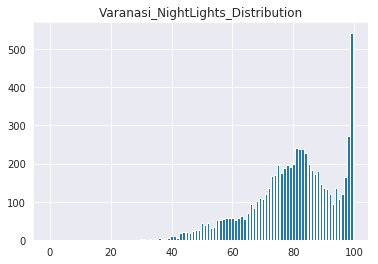

In [39]:
plt.clf()
tempArray1=flattened_DataDictionary['Varanasi@9@197.tif'].copy()
tempArray2=np.log(2+tempArray1)
tempArray = tempArray2[~np.isnan(tempArray2)]
binning=np.histogram(tempArray, bins=percentileValues)
x = np.arange(len(binning[0]))
plt.bar(x, binning[0])
plt.title('Varanasi_NightLights_Distribution')
plt.show()

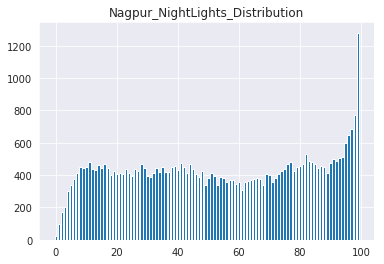

In [38]:
plt.clf()
tempArray1=flattened_DataDictionary['Nagpur@27@505.tif'].copy()
tempArray2=np.log(2+tempArray1)
tempArray = tempArray2[~np.isnan(tempArray2)]
binning=np.histogram(tempArray, bins=percentileValues)
x = np.arange(len(binning[0]))
plt.bar(x, binning[0])
plt.title('Nagpur_NightLights_Distribution')
plt.show()

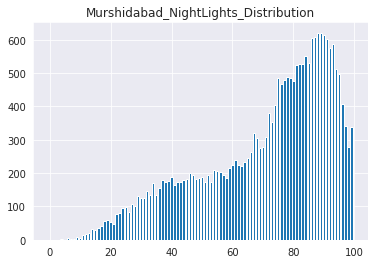

In [37]:
plt.clf()
tempArray1=flattened_DataDictionary['Murshidabad@19@333.tif'].copy()
tempArray2=np.log(2+tempArray1)
tempArray = tempArray2[~np.isnan(tempArray2)]
binning=np.histogram(tempArray, bins=percentileValues)
x = np.arange(len(binning[0]))
plt.bar(x, binning[0])
plt.title('Murshidabad_NightLights_Distribution')
plt.show()

In [18]:
flattened_DataDictionary.keys()

dict_keys(['Chandigarh@4@55.tif', 'Tirunelveli@33@628.tif', 'Udalguri@18@326.tif', 'Washim@27@502.tif', 'West Kameng@12@246.tif', 'Surat@24@492.tif', 'Baramula@1@8.tif', 'North Tripura@16@292.tif', 'Kollam@32@600.tif', 'Lower Subansiri@12@255.tif', 'Palwal@6@89.tif', 'Ramgarh@20@361.tif', 'Mirzapur@9@199.tif', 'Ghazipur@9@195.tif', 'Bikaner@8@101.tif', 'Mahe@34@636.tif', 'South@11@243.tif', 'Tiruvannamalai@33@606.tif', 'Udupi@29@569.tif', 'Bellary@29@565.tif', 'Agra@9@146.tif', 'Jamui@10@238.tif', 'Harda@23@448.tif', 'Sonipat@6@76.tif', 'Gondiya@27@507.tif', 'Hailakandi@18@318.tif', 'Churachandpur@14@274.tif', 'Bhopal@23@444.tif', 'Panchkula@6@69.tif', 'Sonbhadra@9@200.tif', 'Jhalawar@8@129.tif', 'South@7@98.tif', 'Mahendragarh@6@84.tif', 'Sawai Madhopur@8@108.tif', 'Shimla@2@33.tif', 'South 24 Parganas@19@343.tif', 'Pratapgarh@8@131.tif', 'Jaintia Hills@17@299.tif', 'Kapurthala@3@36.tif', 'Hisar@6@80.tif', 'Mandi@2@27.tif', 'Faridabad@6@88.tif', 'Hoshangabad@23@449.tif', 'Hoshiarpur@3